In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

sns.set(font_scale=1.5, style='whitegrid')

## Mixture of Two Gaussians

In [2]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

class MoG2(nn.Module):
  def __init__(self):
    super().__init__()

    self.p1 = MultivariateNormal(torch.zeros(2) + 2., covariance_matrix=.5 * torch.eye(2))
    self.p2 = MultivariateNormal(torch.zeros(2) - 2., covariance_matrix=torch.eye(2))

  def forward(self, x):
    log_half = torch.tensor(1/2).log()
    v1 = self.p1.log_prob(x) + log_half
    v2 = self.p2.log_prob(x) + log_half

    return torch.stack([v1, v2]).logsumexp(0)

### Likelihood Module

In [3]:
class LL(nn.Module):
  '''Log-likelihood Module'''
  def __init__(self):
    super().__init__()

    self.theta = nn.Parameter(2. * torch.randn(1,2))
    self.mog = MoG2()

  def forward(self):
    return self.mog(self.theta)

In [4]:
from torch_sgld import SGLD, CosineLR

f = LL()
T = int(1e4)
n_cycles = 4
lr = .5

sgld = SGLD(f.parameters(), lr=lr, momentum=.9)
sgld_scheduler = CosineLR(sgld, n_cycles=n_cycles, n_samples=2000, T_max=T)

samples = []
for t in tqdm(range(T)):
  sgld.zero_grad()

  v = -f()
  v.backward()

  if sgld_scheduler.get_last_beta() <= sgld_scheduler.beta:
    sgld.step(noise=False)
  else:
    sgld.step()

    if sgld_scheduler.should_sample():
      samples.append(f.theta.detach().clone())

  sgld_scheduler.step()

samples = torch.stack(samples).squeeze(1)

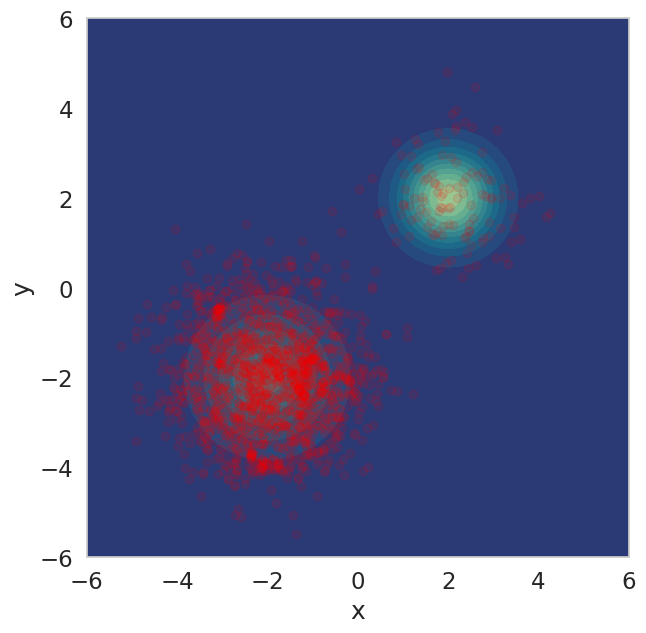

In [6]:
#grid = torch.stack(torch.meshgrid(
#    torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100), indexing='ij')).permute(1, 2, 0) # 100 x 100 x 2

grid = torch.stack(torch.meshgrid(
    torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))).permute(1, 2, 0) # 100 x 100 x 2

mog = MoG2()
logpgrid = mog(grid)

fig, ax = plt.subplots(figsize=(7,7))

ax.contourf(grid[..., 0].numpy(), grid[..., 1].numpy(), logpgrid.exp().numpy(), levels=10,
            cmap=sns.color_palette("crest_r", as_cmap=True))

ax.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), c='red', alpha=.1)

ax.set(xlabel='x', ylabel='y')

fig.show()